In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm

from tqdm import tqdm
from matplotlib import pyplot as plt

from util.data import read_data
from util.features import *

import warnings
warnings.filterwarnings("ignore")

countries, data = read_data(update=True)
data.head()

confirmed.csv loaded
deaths.csv loaded
confirmed_ru.csv loaded
deaths_ru.csv loaded


,date,country,confirmed,deaths
0,2020-02-24,AFG,1,0
1,2020-02-25,AFG,1,0
2,2020-02-26,AFG,1,0
3,2020-02-27,AFG,1,0
4,2020-02-28,AFG,1,0


# Обучаем модель

In [2]:
PREDICT_DAYS = 8
ARIMA_PARAMS = {
    'seasonal': False,
    'suppress_warnings': True,
}


def predict_arima(data, country, predict_days=PREDICT_DAYS):
    country_data = data[data['country'] == country]

    model_confirmed = pm.auto_arima(country_data['confirmed'].values, **ARIMA_PARAMS)
    preds_confirmed, conf_confirmed = model_confirmed.predict(n_periods=predict_days, return_conf_int=True)

    model_deaths = pm.auto_arima(country_data['deaths'].values, **ARIMA_PARAMS)
    preds_deaths, conf_deaths = model_deaths.predict(n_periods=predict_days, return_conf_int=True)
    
    return pd.DataFrame({
        'date': pd.date_range(country_data['date'].max() + pd.to_timedelta(1, unit='d'), periods=predict_days),
        'country': country,
        'prediction_confirmed': preds_confirmed,
        'prediction_confirmed_lower': conf_confirmed[:, 0],
        'prediction_confirmed_upper': conf_confirmed[:, 1],
        'prediction_deaths': preds_deaths,
        'prediction_deaths_lower': conf_deaths[:, 0],
        'prediction_deaths_upper': conf_deaths[:, 1],
    })


preds = data.copy()

for country in tqdm(data['country'].unique()):
    preds = preds.append(predict_arima(data, country))

preds = preds.sort_values(by=['country', 'date']).reset_index(drop=True)

100%|██████████| 253/253 [04:25<00:00,  1.05s/it]


# Визуализация предсказаний

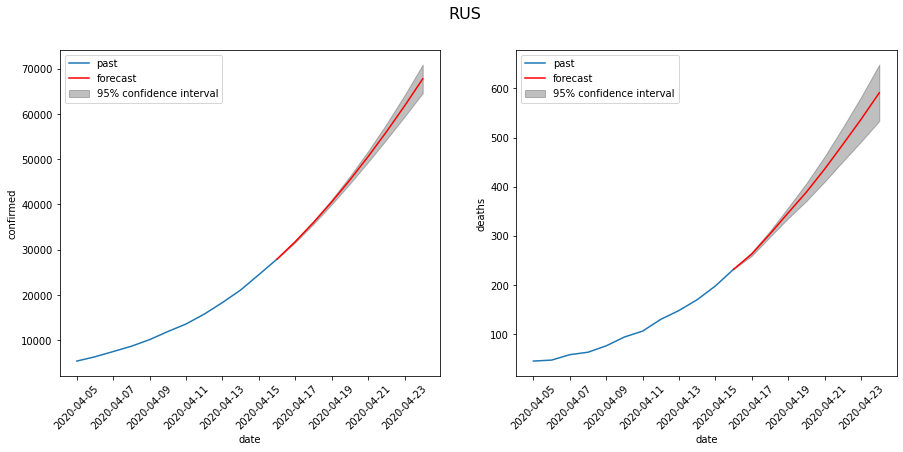

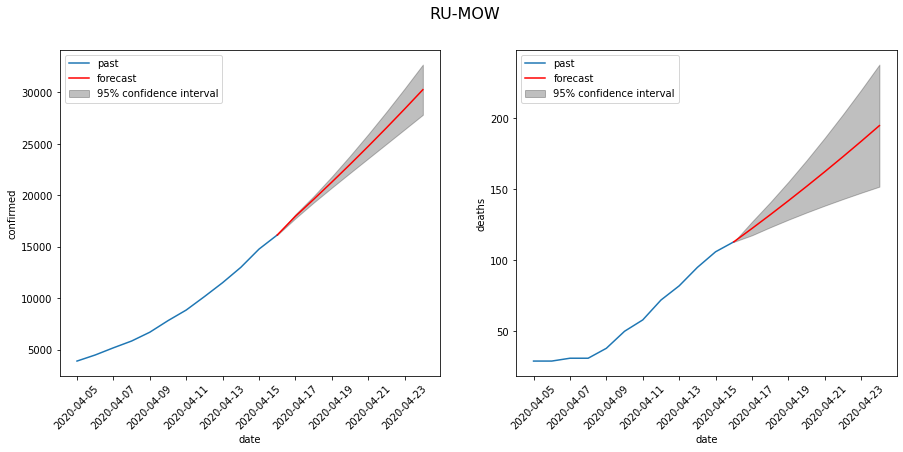

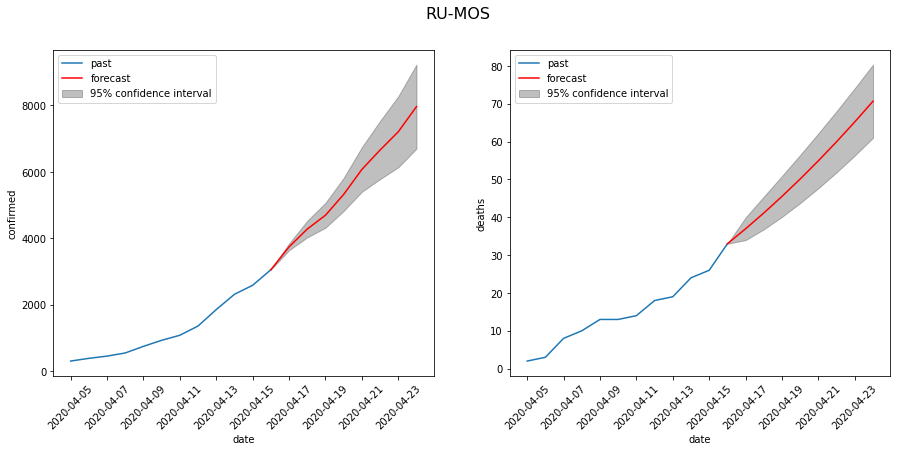

In [3]:
def plot_target(data, country, target, num_days=20):
    plot_data = data[data['country'] == country].tail(num_days).copy()
    plot_data.index = plot_data['date']

    plot_data.loc[plot_data[target].idxmax(), [
        f'prediction_{target}',
        f'prediction_{target}_lower',
        f'prediction_{target}_upper' ]
    ] = plot_data[target].max()
    
    plt.plot(plot_data[target])
    plt.plot(plot_data[f'prediction_{target}'], color="red")
    plt.xlabel('date')
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.fill_between(
        plot_data[f'prediction_{target}'].index, 
        plot_data[f'prediction_{target}_lower'], 
        plot_data[f'prediction_{target}_upper'], 
        color="k", 
        alpha=0.25,
    )
    plt.legend(("past", "forecast", "95% confidence interval"), loc="upper left")


def plot_country(data, country, num_days=20):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plot_target(data, country, 'confirmed', num_days)
    
    plt.subplot(1, 2, 2)
    plot_target(data, country, 'deaths', num_days)

    plt.suptitle(country, fontsize=16)
    plt.show()


plot_country(preds, 'RUS')
plot_country(preds, 'RU-MOW')
plot_country(preds, 'RU-MOS')